<a href="https://colab.research.google.com/github/aksanaboo/sephora/blob/main/SephoraEDApart3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import re
from collections import Counter
from sklearn.metrics import jaccard_score
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

In [40]:
#datasets
product = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/product_info.csv')
review_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews_0-250.csv')
review_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews_250-500.csv')
review_3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews_500-750.csv')
review_4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews_750-1250.csv')
review_5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews_1250-end.csv')

<ipython-input-40-e4867818210a>:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  review_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews_0-250.csv')
<ipython-input-40-e4867818210a>:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  review_4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews_750-1250.csv')
<ipython-input-40-e4867818210a>:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  review_5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews_1250-end.csv')


In [41]:
product.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


In [42]:
product.columns

Index(['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count',
       'rating', 'reviews', 'size', 'variation_type', 'variation_value',
       'variation_desc', 'ingredients', 'price_usd', 'value_price_usd',
       'sale_price_usd', 'limited_edition', 'new', 'online_only',
       'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category',
       'secondary_category', 'tertiary_category', 'child_count',
       'child_max_price', 'child_min_price'],
      dtype='object')

In [43]:
##ingredient analysis

In [44]:
product['ingredients']

0       ['Capri Eau de Parfum:', 'Alcohol Denat. (SD A...
1       ['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...
2       ['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...
3       ['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...
4       ['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...
                              ...                        
8489    ['Talc, Synthetic Fluorphlogopite, Triethylhex...
8490    ['Alcohol, Aqua / Water / Eau, Parfum / Fragra...
8491    ['Mon Paris Eau de Parfum:', 'Alcohol, Parfum/...
8492    ['Alcohol, Parfum/Fragrance, Aqua/Water, Limon...
8493    ['Diisostearyl Malate, Bis-Behenyl/Isostearyl/...
Name: ingredients, Length: 8494, dtype: object

In [45]:
ingredient = product[['product_name','brand_name','rating','ingredients']]

In [46]:
ingredient.head()

,product_name,brand_name,rating,ingredients
0,Fragrance Discovery Set,19-69,3.6364,"['Capri Eau de Parfum:', 'Alcohol Denat. (SD A..."
1,La Habana Eau de Parfum,19-69,4.1538,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra..."
2,Rainbow Bar Eau de Parfum,19-69,4.2500,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra..."
3,Kasbah Eau de Parfum,19-69,4.4762,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra..."
4,Purple Haze Eau de Parfum,19-69,3.2308,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra..."


In [47]:
ingredient.dropna(inplace=True)

<ipython-input-47-72f389d13587>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingredient.dropna(inplace=True)


In [48]:
ingredient['ingredients'][0]

"['Capri Eau de Parfum:', 'Alcohol Denat. (SD Alcohol 39C), Parfum (Fragrance) D-Limonene, Linalool, Benzyl Salicylate, Ethylhexyl Methoxycinnamate, Butyl Methoxydibenzoylmethane, Ethylhexyl Salicylate, Benzl Benzoate, Citral, Geraniol, Eugenol, Benzyl Alcohol, Farnesol, Citronellol, Isoeugenol.', 'Invisible Post Eau de Parfum:', 'Alcohol Denat. (SD Alcohol 39C), Parfum (Fragrance) Ethylhexyl Methoxycinnamate, Ethylhexyl Salicylate, Butyl Methoxydibenzoylmethane, Benzyl Benzoate, Citral, Coumarin, Limonene, Alpha-Isomethyl Ionone, Linalool.', 'Kashbah Eau de Parfum:', 'Alcohol Denat. (SD Alcohol 39C), Parfum (Fragrance) Coumarin, Ethylhexyl Methoxycinnamate, Butyl Methoxydibenzoylmethane, Ethylhexyl Salicylate, D-Limonene, Eugenol, Linalool, Citronellol, Geraniol, Cinnamal, Citral.', 'L’Air Barbes Eau de Parfum:', 'Alcohol Denat. (SD Alcohol 39C), Parfum (Fragrance) Benzyl Salicylate, D-Limonene, Ethylhexyl Methoxycinnamate, Butyl Methoxydibenzoylmethane, Ethylhexyl Salicylate, Linaloo

In [49]:
len(ingredient['ingredients'][0])

1906

In [50]:
#remove extra spaces
len(ingredient['ingredients'][0].split())

199

In [51]:
#ingredient count
ingredient['ingredient_count'] = ingredient['ingredients'].apply(lambda x: len(x.split()))

<ipython-input-51-9c9b385ad6bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingredient['ingredient_count'] = ingredient['ingredients'].apply(lambda x: len(x.split()))


In [52]:
#stats
ingredient['ingredient_count'].describe()

count    7322.00000
mean       82.29186
std        84.68093
min         1.00000
25%        39.00000
50%        64.00000
75%        96.00000
max      2064.00000
Name: ingredient_count, dtype: float64

In [53]:
ingredient.head()

,product_name,brand_name,rating,ingredients,ingredient_count
0,Fragrance Discovery Set,19-69,3.6364,"['Capri Eau de Parfum:', 'Alcohol Denat. (SD A...",199
1,La Habana Eau de Parfum,19-69,4.1538,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",27
2,Rainbow Bar Eau de Parfum,19-69,4.2500,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",23
3,Kasbah Eau de Parfum,19-69,4.4762,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",21
4,Purple Haze Eau de Parfum,19-69,3.2308,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",21


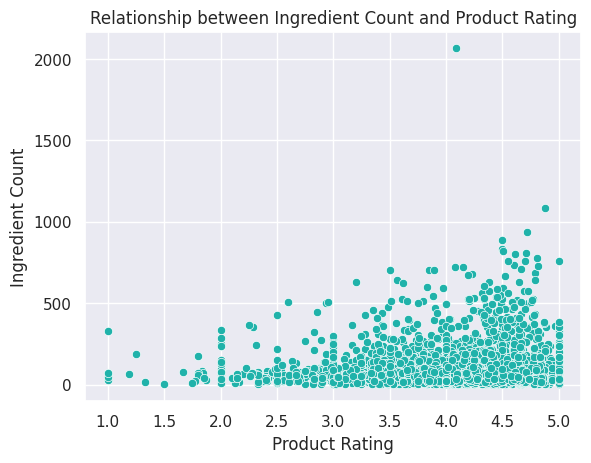

In [54]:
#relationship between ingredient count and rating
sns.set(style='darkgrid')
sns.scatterplot(data=ingredient,x='rating',y='ingredient_count',color='#20b2aa')
plt.xlabel('Product Rating')
plt.ylabel('Ingredient Count')
plt.title('Relationship between Ingredient Count and Product Rating')
plt.show()

In [55]:
ingredient['ingredients'] = ingredient['ingredients'].str.replace(r'\[|\]', '', regex=True)

<ipython-input-55-267683cf6efb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingredient['ingredients'] = ingredient['ingredients'].str.replace(r'\[|\]', '', regex=True)


In [56]:
ingredient['ingredients'][0]

"'Capri Eau de Parfum:', 'Alcohol Denat. (SD Alcohol 39C), Parfum (Fragrance) D-Limonene, Linalool, Benzyl Salicylate, Ethylhexyl Methoxycinnamate, Butyl Methoxydibenzoylmethane, Ethylhexyl Salicylate, Benzl Benzoate, Citral, Geraniol, Eugenol, Benzyl Alcohol, Farnesol, Citronellol, Isoeugenol.', 'Invisible Post Eau de Parfum:', 'Alcohol Denat. (SD Alcohol 39C), Parfum (Fragrance) Ethylhexyl Methoxycinnamate, Ethylhexyl Salicylate, Butyl Methoxydibenzoylmethane, Benzyl Benzoate, Citral, Coumarin, Limonene, Alpha-Isomethyl Ionone, Linalool.', 'Kashbah Eau de Parfum:', 'Alcohol Denat. (SD Alcohol 39C), Parfum (Fragrance) Coumarin, Ethylhexyl Methoxycinnamate, Butyl Methoxydibenzoylmethane, Ethylhexyl Salicylate, D-Limonene, Eugenol, Linalool, Citronellol, Geraniol, Cinnamal, Citral.', 'L’Air Barbes Eau de Parfum:', 'Alcohol Denat. (SD Alcohol 39C), Parfum (Fragrance) Benzyl Salicylate, D-Limonene, Ethylhexyl Methoxycinnamate, Butyl Methoxydibenzoylmethane, Ethylhexyl Salicylate, Linalool

In [57]:
ingredient['ingredients'] = ingredient['ingredients'].str.replace("'", "",regex=True)

<ipython-input-57-5e1ca3e35f64>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingredient['ingredients'] = ingredient['ingredients'].str.replace("'", "",regex=True)


In [89]:
ingredient.columns

Index(['product_name', 'brand_name', 'rating', 'ingredients',
       'ingredient_count', 'ingredient_list', 'unique_ingredients', 'cluster'],
      dtype='object')

In [58]:
ingredient['ingredients'][0]

'Capri Eau de Parfum:, Alcohol Denat. (SD Alcohol 39C), Parfum (Fragrance) D-Limonene, Linalool, Benzyl Salicylate, Ethylhexyl Methoxycinnamate, Butyl Methoxydibenzoylmethane, Ethylhexyl Salicylate, Benzl Benzoate, Citral, Geraniol, Eugenol, Benzyl Alcohol, Farnesol, Citronellol, Isoeugenol., Invisible Post Eau de Parfum:, Alcohol Denat. (SD Alcohol 39C), Parfum (Fragrance) Ethylhexyl Methoxycinnamate, Ethylhexyl Salicylate, Butyl Methoxydibenzoylmethane, Benzyl Benzoate, Citral, Coumarin, Limonene, Alpha-Isomethyl Ionone, Linalool., Kashbah Eau de Parfum:, Alcohol Denat. (SD Alcohol 39C), Parfum (Fragrance) Coumarin, Ethylhexyl Methoxycinnamate, Butyl Methoxydibenzoylmethane, Ethylhexyl Salicylate, D-Limonene, Eugenol, Linalool, Citronellol, Geraniol, Cinnamal, Citral., L’Air Barbes Eau de Parfum:, Alcohol Denat. (SD Alcohol 39C), Parfum (Fragrance) Benzyl Salicylate, D-Limonene, Ethylhexyl Methoxycinnamate, Butyl Methoxydibenzoylmethane, Ethylhexyl Salicylate, Linalool Citral, Alphai

In [59]:
ingredient['ingredient_list'] = ingredient['ingredients'].apply(lambda x: x.split(', '))

<ipython-input-59-13082a679089>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingredient['ingredient_list'] = ingredient['ingredients'].apply(lambda x: x.split(', '))


In [61]:
ingredient_counts = Counter(ingredient for ingredients in ingredient['ingredient_list'] for ingredient in ingredients)

In [62]:
ingredient_df = pd.DataFrame.from_dict(ingredient_counts, orient='index', columns=['count'])
ingredient_df = ingredient_df.reset_index().rename(columns={'index': 'ingredient'})

In [63]:
ingredient_df = ingredient_df.sort_values(by='count', ascending=False)

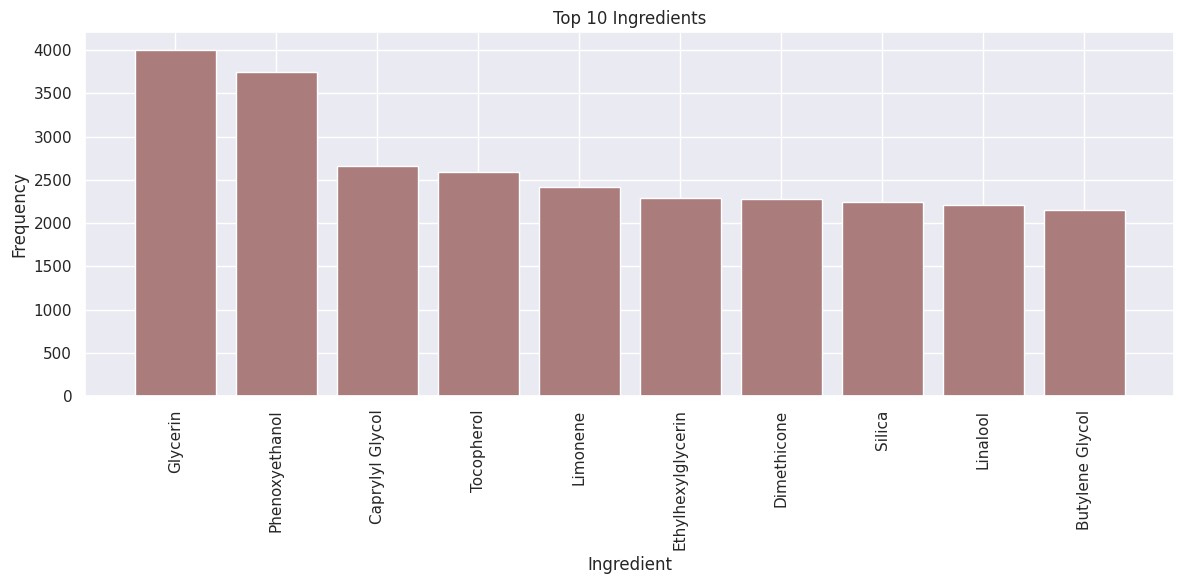

In [68]:
# Top 10 ingredients present in Products
top_n = 10
top_ingredients = ingredient_df.head(top_n)

plt.figure(figsize=(12, 6))
plt.bar(top_ingredients['ingredient'], top_ingredients['count'],color='#aa7c7c')
plt.xlabel('Ingredient')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Ingredients')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [70]:
# Create a set of unique ingredients for each product
ingredient['unique_ingredients'] = ingredient['ingredient_list'].apply(set)

<ipython-input-70-349ba85fb6e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingredient['unique_ingredients'] = ingredient['ingredient_list'].apply(set)


In [76]:
all_unique_ingredients = set()
for unique_ingredient_set in ingredient['unique_ingredients']:
    all_unique_ingredients.update(unique_ingredient_set)

In [77]:
binary_matrix = np.zeros((len(ingredient), len(all_unique_ingredients)), dtype=int)
for i, unique_ingredient_set in enumerate(ingredient['unique_ingredients']):
    for j, unique_ingredient in enumerate(all_unique_ingredients):
        if unique_ingredient in unique_ingredient_set:
            binary_matrix[i, j] = 1

In [80]:
jaccard_distances = pdist(binary_matrix, metric='jaccard')

In [81]:
n_clusters = 2
clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
ingredient['cluster'] = clustering.fit_predict(squareform(jaccard_distances))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
<ipython-input-81-e1ec50d3dc19>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingredient['cluster'] = clustering.fit_predict(squareform(jaccard_distances))


In [82]:
for cluster_id in range(n_clusters):
    cluster_products = ingredient[ingredient['cluster'] == cluster_id]['product_name'].tolist()
    print(f'Cluster {cluster_id + 1}: {cluster_products}')

Cluster 1: ['Contouring + De-Puffing Rose Quartz Roller', 'Contouring + De-Puffing Rose Quartz GloPRO Attachment Head', 'BEAUTYBLUSHER Makeup Sponge', 'Biopure Sustainable Green Makeup Sponge', 'Dream Makeup Sponge', '100% Sugarcane Squalane Oil', 'Slow Burn Candle', 'LES Candle', 'Cameo, Hinoki Fantôme, LES Mini Candle Trio Set', 'Cashmere Kush Candle', 'Mini Candle Trio Set', 'Hinoki Fantôme Candle', 'Copal Fantome Candle', 'Broken Rosary Candle', 'Polyamberous Candle', 'Cedar Stack Candle', 'Cameo Candle', 'Thé Fantôme Candle', 'Lanai Candle', 'Neopeche Candle', 'Be Gentle, Be Kind Avocado + Kiwi Mega Moisture Superfoods Hair Mask', 'Be Gentle, Be Kind Aloe + Oat Milk Ultra Soothing Fragrance-Free Detangler', 'Superfoods Banana + Coconut Nourishing Conditioner', 'Full-On Plumping Lip Polish Gloss', 'Eye Smudger Brush', 'Makeup Brush Cleaner', 'Makeup Brush Cleaner Pro Starter Kit', 'Makeup Brush Cleaner Mini', 'Honey Grail Ultra-Hydrating Face Oil', 'Age Adapting CBD Serum', 'APHROD

In [86]:
ingredient['cluster'].value_counts()

1    7174
0     148
Name: cluster, dtype: int64

In [91]:
cluster_0 = ingredient[ingredient['cluster'] == 0]
cluster_1 = ingredient[ingredient['cluster'] == 1]

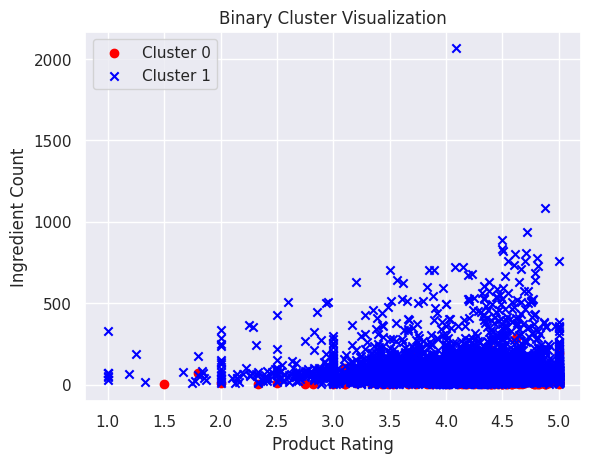

In [95]:
plt.scatter(cluster_0['rating'], cluster_0['ingredient_count'], c='red', marker='o', label='Cluster 0')
plt.scatter(cluster_1['rating'], cluster_1['ingredient_count'], c='blue', marker='x', label='Cluster 1')

plt.xlabel('Product Rating')
plt.ylabel('Ingredient Count')
plt.title('Binary Cluster Visualization')
plt.legend()
plt.show()

In [104]:
fig = px.scatter(
    ingredient,
    x='rating',
    y='ingredient_count',
    color='cluster',
    title='Binary Cluster Visualization',
    labels={'rating': 'Product Rating', 'ingredient_count': 'Ingredient Count'},
    color_discrete_sequence=['red', 'blue'], opacity=0.4
)

# Customize the appearance of markers (optional)
fig.update_traces(marker=dict(size=12, symbol='circle'), selector=dict(mode='markers'))

# Show the plot interactively
fig.show()


In [105]:
# can look for more Ingredient clusters